## Andrej Karpathy's /micrograd

### Backpropagation 

NN are mathematical expressions that take the inputs and weights as input, and thee output is either some sort of 
prediction or a loss-function. Backpropagation is a general algorithm that is being used on mathematical expressions
and therefore we can use it with NN.

Micrograd's library consists of two main classes: engine and nn. Engine is the back-prop logic and nn is simply a
definition of a nn. This gives what we need to build a NN, what remains is optimization.

In [99]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
def f(x):
    return 3*x**2 - 4*x + 5

In [101]:
f(3.0)

20.0

get a sense of how f(x) looks like

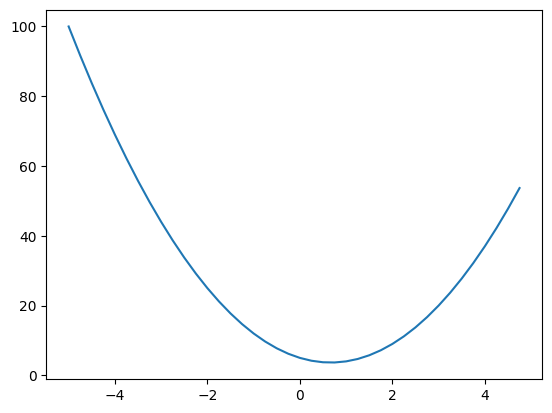

In [102]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

let's figure out the derivate at any point x, on f(x). one way to do that is to derive the derivate based on the symbolic measures of transforming f(x) expression. but in ML no one does that, since the expression is huge. so let's instead try to understand what is achieved by a derivative so we can code it.

here is the definition of derivative:

$$
L = \lim_{h->0} \frac{f(x + h) - f(x)}{h}\
$$

this means that, if we add a small value $h$ to $f(x)$, we are interested to understand the implications in terms of its behavior on the new point's slope and direction.

let's see that based on our $f(x)$

In [103]:
h = 0.001 # be careful how small this would be so you won't a limitation on computer memory
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

let's start looking into a more complex function, $d$

In [104]:
a = 2.0
b= -3.0
c = 10.0
d = a*b + c
print(d)

4.0


let's figure out the derivative of d in respect to $a$, $b$ and $c$

In [105]:
h = 0.0001

# inputs
a = 2.0
b= -3.0
c = 10.0
d1 = a*b + c

# find the derivative of d, in respect to a
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2) # if d2 is less than d1, it means that the slope is negative; which can be calculate from the last print
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


now let's evaluate the impact of $b$ on $d$. this time we'll bump up $b$ a little by adding a small $h$

In [106]:
h = 0.0001

# inputs
a = 2.0
b= -3.0
c = 10.0
d1 = a*b + c

# find the derivative of d, in respect to a
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2) # if d2 is less than d1, it means that the slope is negative; which can be calculate from the last print
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


#### Derivatives in correspondence to NNs
here we want to move to NNs. these huge mathematical expressions so we'll start with building the corresponding data structure for it

In [107]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')

In [108]:
#example
a = Value(2.0, label='a')
b = Value(-3.0, label='b')    
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L; L.label='L' # graph output

In [109]:
d

Value(data=4.0)

In [110]:
# children of value d
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [111]:
# operations between the children resulting in value d
d._op

'+'

below code is to assist in visualizing the provided value in a graph-like representation 

In [112]:
# https://graphviz.org/download/
# macOS:
# /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
# brew install graphviz
from graphviz import Digraph

In [113]:

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right

    nodes, edges = trace(root)    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record) node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

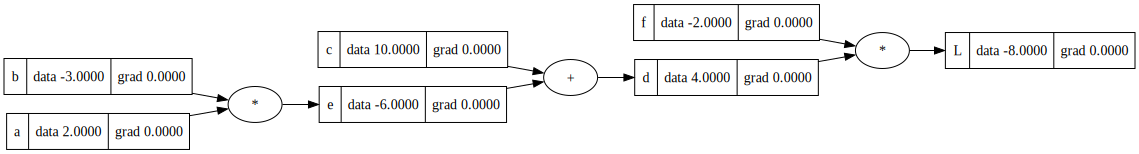

In [114]:
# demonstrates the forward path of the values resulting in the output L
draw_dot(L)

#### Backpropagation
we will go backwards from L and calculate the gradients along all the intermediate values; i.e. d, f, c and etc. This means, we'll calculate the derivative of each node in respect to L. In NN, we are interested in the derivative of the output L, in respect to its weights. Because we need to understand how those weights impact the loss-function, L. The derivative of L in respect to input-data, (i.e. a and b) are irrelevant to NN because they are fixed, however, the weights are going to be iterative. 



In [115]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')    
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L; L.label='L' # graph output
    L1 = L.data

    a = Value(2.0 + h, label='a') # find the derivative of L in respect to a
    b = Value(-3.0, label='b')    
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L; L.label='L' # graph output
    L2 = L.data

    print((L2 - L1)/h)
lol()

6.000000000021544


let's find the derivative of $L$ in respect to $d$. we know it's $f$, so let's see the proof:
$$
L = d \times f
$$

$$
\frac {\partial L}{\partial d} = f
$$

proof:

$$
\frac {f(x+h) - f(x)}{h} = \frac {((d+h) \times f) - (d \times f)}{h} = \frac {d \times f + h \times f - d \times f}{h} = \frac {h \times f}{h} = f
$$

the calculations for f will be similar to d. now let's understand dL/dc. we know dL/dd and we also can easily find out dd/dc. so we should be able to find out dL/dc.

$$
\frac {\partial L}{\partial d} = f
$$

$$
\frac {\partial d}{\partial c} = \frac {c+h+e - c+e}{h} = 1
$$

based on the chain rule:

$$
\frac {\partial L}{\partial c} = \frac {\partial L}{\partial d} \times \frac {\partial d}{\partial c} = f \times 1 = f
$$

this means that the plus sign in $d = c + e$ passes through the gradient on $d$ over to $c$ AND $e$. in other words, the gradient of $d$ is distributed to all the children nodes through plus sign. 


now we are able to add a small value/step to the gradient of the leaf nodes (i.e a, b, c, f) and analyze the impact on the loss-function, L. This would be considered as one step of an optimization that will be useful for training the NN.

each cell body can take multiple $wx$ inputs. $w$ is the synapse or the weight, and $x$'s are the inputs. these will look like $x_0w_0$, $x_1w_1$ and $x_nw_n$. the cell body will add a bias to the sum of such inputs, which is a considered to make the trigger happy. and the result of that is fed into an activation function, such as Sigmoid, Relu or tanh. below is an example of tanh.


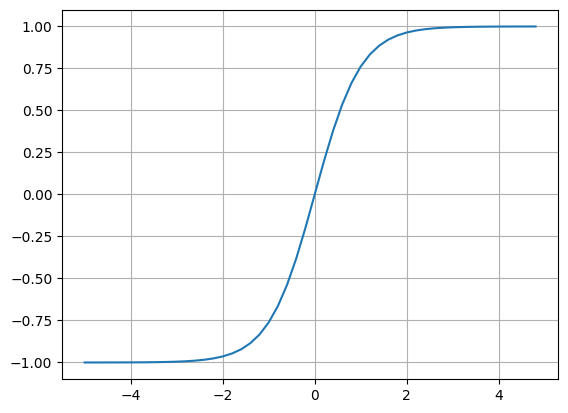

In [116]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

update the value class by adding the implementation for tanh

In [117]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out

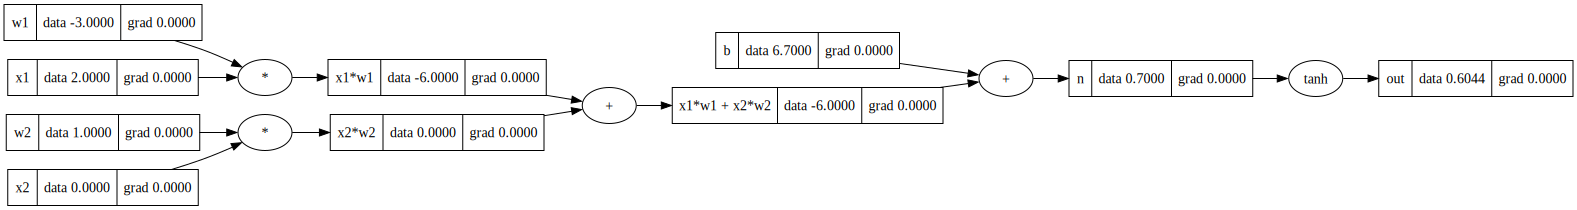

In [118]:
#example
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n' # this is the cell body without activation function
out = n.tanh(); out.label = 'out' # this is the output of the neuron
draw_dot(out)

$$
out = tanh(n)
$$
$$
\frac {\partial out}{\partial n} = 1 - out ^ 2
$$

now it's time to implement the backpropagation so we can get the gradients automatically. So let's further update the Value class.

In [119]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
        self._backward = lambda: None # this function will define how we chain the output gradient to the input gradient
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
        def _backward(): 
            # we saw in the addition op, the gradient of output is cascaded to the children
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            self.other = self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

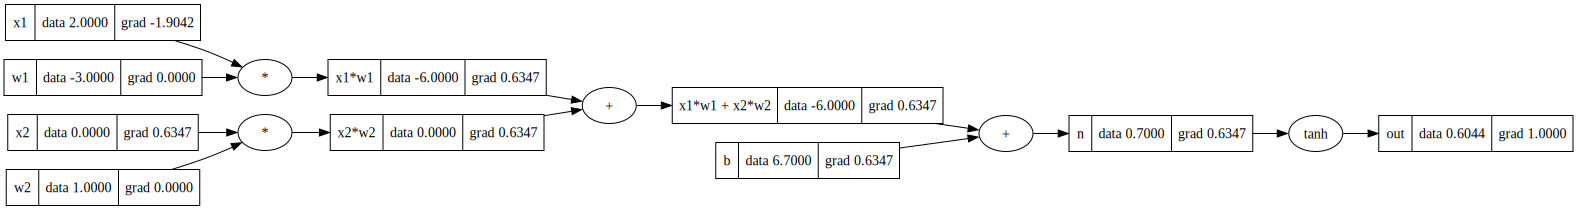

In [120]:
#example
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n' # this is the cell body without activation function
out = n.tanh(); out.label = 'out' # this is the output of the neuron

#preset output gradient
out.grad = 1.0 # initialize the grad
# call the non-leaf nodes backward function
out._backward()
n._backward()
x1w1_x2w2._backward()
x1w1._backward()
x2w2._backward()
# draw the graph
draw_dot(out)

now we should automate the backward call. we need to build a topological sort to have a left to right type of navigation. 

In [121]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

In [122]:
# add out to the list and get the topological order
build_topo(out)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.7),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

In [123]:
# you need to treat the list above in reverse, because the last value in the list belongs to the out while you want to start from that for you backpropagation
for node in reversed(topo):
    node._backward()
    

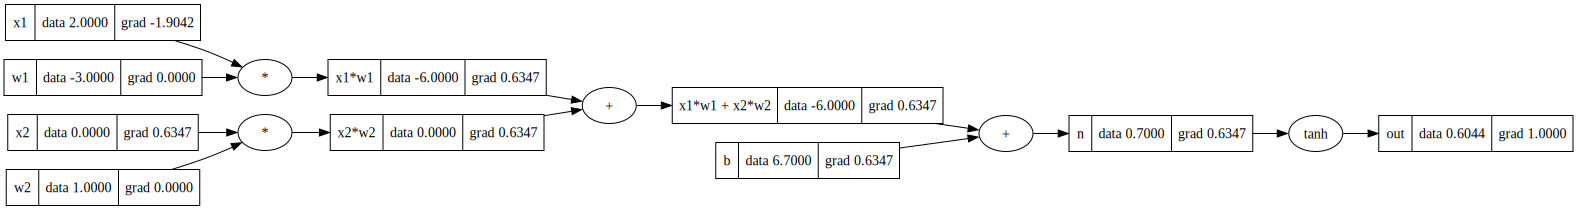

In [124]:
draw_dot(out)

now update the value class to include the automated backpropagation function: backward().

In [125]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
        self._backward = lambda: None # this function will define how we chain the output gradient to the input gradient
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
        def _backward(): 
            # we saw in the addition op, the gradient of output is cascaded to the children
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            self.other = self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self,):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0 # initialize the grad
        for node in reversed(topo):
            node._backward()

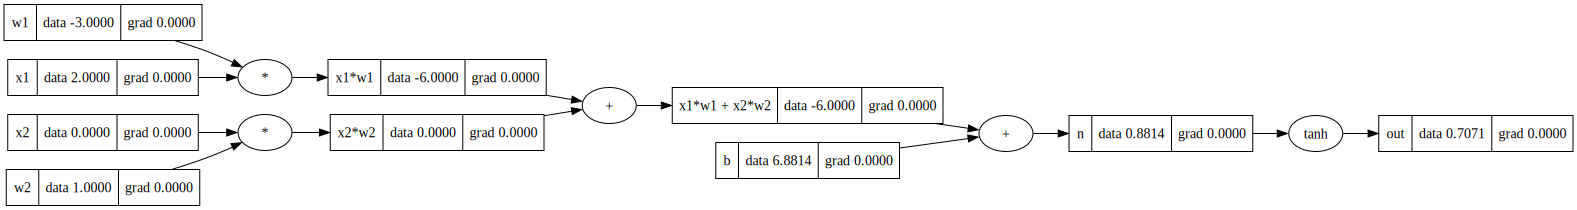

In [126]:
#example
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n' # this is the cell body without activation function
out = n.tanh(); out.label = 'out' # this is the output of the neuron
draw_dot(out)

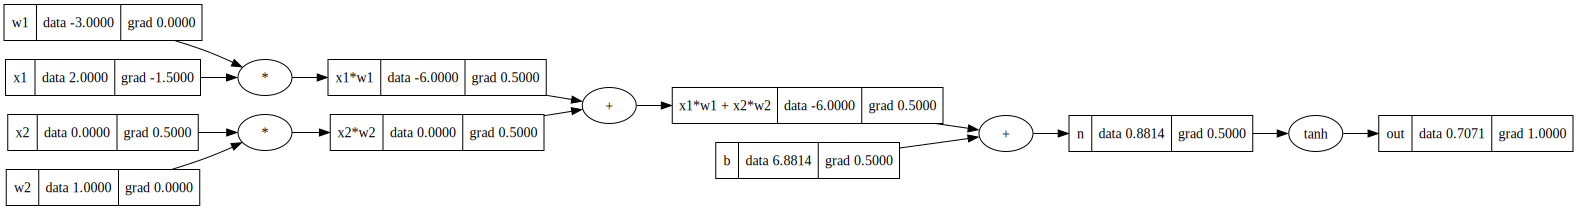

In [127]:
out.backward()
draw_dot(out)

there is an issue when the children are the same. think about a situation where b = a + a. grad = 1 while it has to be 2.
the issue is that we missed accumulating the gradient values; i.e. 

```python
self.grad += 1.0 + out.grad
```

so here is the retry of the value class:


In [128]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
        self._backward = lambda: None # this function will define how we chain the output gradient to the input gradient
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
        def _backward(): 
            # we saw in the addition op, the gradient of output is cascaded to the children
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self,):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0 # initialize the grad
        for node in reversed(topo):
            node._backward()

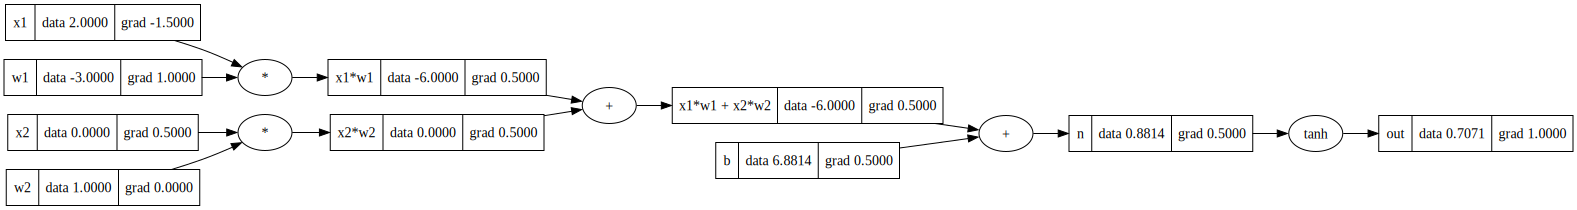

In [129]:
#example
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n' # this is the cell body without activation function
out = n.tanh(); out.label = 'out' # this is the output of the neuron

out.backward()


draw_dot(out)

currently if we have a Value a, we cannot directly add 1 to it, because it considers 1 as other, and the code tries to retrieve other.data and 1.data doesn't exist. so let's add a functionality to our add and multiply functions to be able to interpret such expressions too. 

also, if you do something like 2 * a it will fail, so we need to consider additional code for that too. we'll use rmul for this.

wee'll also add exponentiation functionality through exp.

here we update the division logic that we haven't used so far. this new function is called true dic which uses the power -1.

we also gonna add pow function.

we have updated thee subtraction logic by using ```__neg__``` and ```__sub__```

In [130]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.grad = 0.0 # this is the gradient of the value which is zero at the start
        self.data = data
        self._prev = set(_children) # track the children of every single value. the values corresponding to the new one. these are get a tuple of children and keep the set; for efficiency. 
        self._op = _op # this is the operation between the children that created the new value
        self.label = label # this is the label of the value
        self._backward = lambda: None # this function will define how we chain the output gradient to the input gradient
    
    def __repr__(self):
        return f"Value(data={self.data})"
    ############################################################################################################ ADDITION
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # (self, other) is feeding in the children values
        def _backward(): 
            # we saw in the addition op, the gradient of output is cascaded to the children
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    ############################################################################################################ SUBTRACTION
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    ############################################################################################################ MULTIPLICATION
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # if a * 2 is giving an error, this will check to see if 2 * a is possible, or wise versa
    def __rmul__(self, other):
        return self * other
    ############################################################################################################ DIVISION
    def __truediv__(self, other):
        return self * other**-1
    ############################################################################################################ POWER
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out
    ############################################################################################################ EXPONENTIAL
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out    
    ############################################################################################################ ACTIVATION FUNCTION: TANH
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    ############################################################################################################ BACKPROPAGATION
    def backward(self,):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0 # initialize the grad
        for node in reversed(topo):
            node._backward()

In [131]:
a = Value(2.0)
a + 1 

Value(data=3.0)

In [132]:
2 * a

Value(data=4.0)

In [133]:
a = Value(2.0)
a**3

Value(data=8.0)

In [134]:
a.exp()

Value(data=7.38905609893065)

In [135]:
a = Value(6.0)
b = Value(3.0)
a / b

Value(data=2.0)

In [136]:
a - b

Value(data=3.0)

let's break down tanh function and redraw the graph. so now you see a bigger sequence of the graph because we broke down tanh into smaller operations. this will demonstrate the fact that it's up to you to decide on the granularity of your functions. as long as you can do a forward and backward path on the op, the level of granularity doesn't matter.

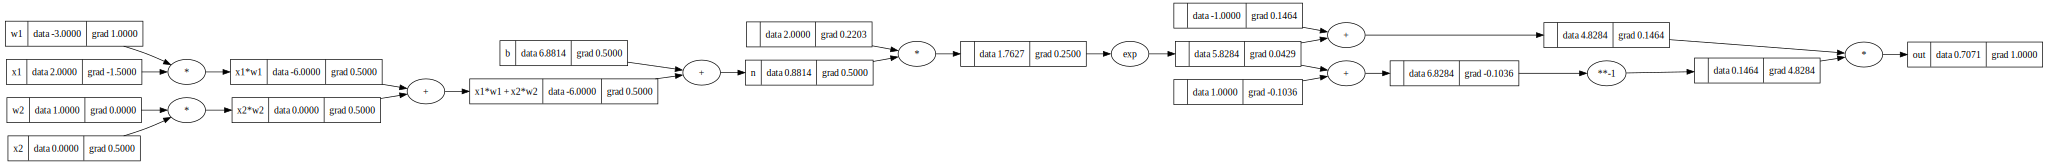

In [137]:
#example
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n' # this is the cell body without activation function

# activation function
e = (2*n).exp()
out =  (e-1) / (e+1)

out.label = 'out' # this is the output of the neuron
out.backward()
draw_dot(out)

here we'll start utilizing pytorch library for setting up the values. below code is similar to what we implemented so far. Tensors are complex scalers, like arrays with multiple values, while we have so far used single digit values for our elements. thee reason we cast our tensors to double in pytorch is to mimic the float64 which we got in python (pytorch default is float32). by default grad component of tensors are false, because it doesn't want to add overhead when it's not needed.

pytorch, similar to micrograd had .data and .grad operations. 

In [138]:
import torch

x1 = torch.Tensor([2.0]).double()                   ;   x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ;   x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ;   w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ;   w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ;   b.requires_grad = True
n = x1*w1 + x2*w2 + b
out = torch.tanh(n)

print(out.data.item())
out.backward()

print('---')
print(x2.grad.item())
print(w2.grad.item())
print(x1.grad.item())
print(w1.grad.item())

0.7071066904050358
---
0.5000001283844369
0.0
-1.5000003851533106
1.0000002567688737


In [139]:
# here is how out tensor looks like
out

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

#### Building the NN
we'll start with building a Neuron class

In [140]:
import random
class Neuron:
    # nin is number of inputs that comes into the neuron
    def __init__(self, nin):
        self.w = list(Value(random.uniform(-1, 1)) for _ in range(nin)) # create random values for weights between -1 and 1
        self.b = Value(random.uniform(-1, 1)) # create the bias, or the trigger happiness 
        print('--w values: ')
        for v in self.w:
            print(v.data)
        print('--b value:\n ', self.b.data)
  

    # executes below example n(x)
    def __call__(self, x):
        # w * x + b
        # multiply each weight by the input, pairwise
        # activation = zip(self.w, x) pair up the w's with x's, and then we'll multiply them pairwise
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # sum(iterable, start) = sum(wi*xi, 0.0). if we don't identify the start as Value(b), it will fail
        print('--activation + b:\n ', act.data)
        out = act.tanh()
        print('--out: ')
        return out


In [141]:
# test the neuron: each execution will give a different result, because the weights and bias are random
x = [2.0, 3.0]
n = Neuron(2)
n(x)

--w values: 
-0.820098879177303
0.1490705243948498
--b value:
  0.17289593113059865
--activation + b:
  -1.0200902540394579
--out: 


Value(data=-0.7699032943228874)

now let's build the NN's layer

In [142]:
class Layer:
    # a layer is a list of neurons. nout is the number of neurons in the layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [143]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

--w values: 
0.7915908383949206
0.07171281330019741
--b value:
  -0.48434843380058434
--w values: 
0.41466348692253896
0.13052826167471765
--b value:
  -0.8200829454736578
--w values: 
-0.44773918293654713
-0.9684080183850434
--b value:
  -0.08607747797894683
--activation + b:
  1.3139716828898491
--out: 
--activation + b:
  0.4008288133955731
--out: 
--activation + b:
  -3.8867798990071716
--out: 


[Value(data=0.8652769168105481),
 Value(data=0.3806579037300856),
 Value(data=-0.9991589279601625)]

here we'll build a MLP (multi layer perceptron). a sequence of layers.

In [144]:
class MLP:
    # nouts is the list of layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [145]:
# 3-d input
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs layer, two layers of 4 neurons and one layer of 1 neuron for the output. 3x4x4x1
n(x)

--w values: 
0.08249380376691118
0.05258678545802864
0.6544289855922922
--b value:
  -0.1679534660643871
--w values: 
-0.5644581459848874
-0.1429801421659902
-0.14416006785039048
--b value:
  0.31290284823929815
--w values: 
0.20172223008875778
0.710638233838585
-0.9778195462923207
--b value:
  -0.4223919945160368
--w values: 
0.4900898826968936
0.8838311465123061
-0.05907791408180918
--b value:
  0.8237158705661995
--w values: 
-0.24773752719886488
-0.31855404168617696
-0.9551433512750671
0.24580152409261768
--b value:
  0.895418977706919
--w values: 
0.5585103258920385
0.180698269706008
-0.9181411936966946
0.37983468611569005
--b value:
  0.33506218624879747
--w values: 
0.531241317928935
0.16120204825526496
0.15137754839286433
0.036336242430955235
--b value:
  0.6079789583457804
--w values: 
-0.957351930632218
-0.475178610022958
0.5077503120336664
0.4442321691587132
--b value:
  -0.9738173141847095
--w values: 
0.29466695428898304
0.45680064922307984
0.7168859934340353
0.82344536897

Value(data=0.2289700776921351)

--activation + b:
  -0.49963448774877106
--out: 
--activation + b:
  -1.1007938023780568
--out: 
--activation + b:
  3.090786713469554
--out: 
--activation + b:
  4.514466989578715
--out: 
--activation + b:
  0.5594644735875796
--out: 
--activation + b:
  -0.602184213523961
--out: 
--activation + b:
  0.42062847119850755
--out: 
--activation + b:
  0.7986127026319785
--out: 
--activation + b:
  0.2331022899238976
--out: 


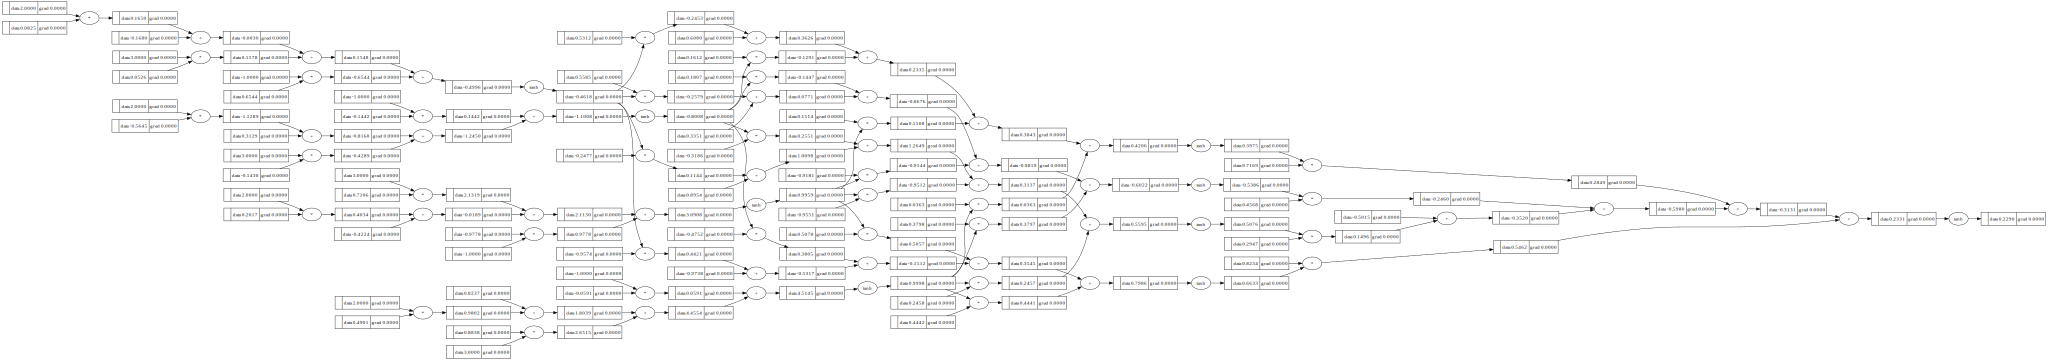

In [146]:
draw_dot(n(x))

In [147]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
# get the prediction of the NN on xs
ypred = [n(x) for x in xs]
ypred

--activation + b:
  -0.49963448774877106
--out: 
--activation + b:
  -1.1007938023780568
--out: 
--activation + b:
  3.090786713469554
--out: 
--activation + b:
  4.514466989578715
--out: 
--activation + b:
  0.5594644735875796
--out: 
--activation + b:
  -0.602184213523961
--out: 
--activation + b:
  0.42062847119850755
--out: 
--activation + b:
  0.7986127026319785
--out: 
--activation + b:
  0.2331022899238976
--out: 
--activation + b:
  0.3541556525744639
--out: 
--activation + b:
  -1.3095714814745691
--out: 
--activation + b:
  -1.016773311234509
--out: 
--activation + b:
  1.3806154151036696
--out: 
--activation + b:
  2.037105766778025
--out: 
--activation + b:
  1.4091380822356583
--out: 
--activation + b:
  0.5649995786356319
--out: 
--activation + b:
  -0.887559693811706
--out: 
--activation + b:
  -0.029371570505024147
--out: 
--activation + b:
  0.5803092068693894
--out: 
--activation + b:
  -0.25646643476952624
--out: 
--activation + b:
  -0.5887121919253936
--out: 
--act

[Value(data=0.2289700776921351),
 Value(data=-0.02936312724014121),
 Value(data=-0.03344701706135134),
 Value(data=0.15585466620149)]

#### Loss Function
as we can see, the predicted values are off, compared to thee actual ys. so thee question is, how to tweak the NN to make ypred closer to ys. loss-function is a measure of how well the NN is doing. we can use a simple function such as mean squared

In [148]:
# shows how far are the ypred from actual ys. wee only get zero when y-out is equal to y-ground-truth
[(yout - ygt)**2 for yout, ygt in zip(ypred, ys)]

[Value(data=0.5944871410940722),
 Value(data=0.9421359387610383),
 Value(data=0.9342246688275997),
 Value(data=0.7125813445737978)]

In [149]:
loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred, ys)), Value(0.0))
loss

Value(data=3.1834290932565086)

we can look at individual weights in our NN now. use below code. for instance when the grad is negative, it means that the impact on the loss function would also be negative. so if we tweak this weight, of this neuron of this layer, by a bit, to make it closer to a positive value, we can improve the loss.

In [150]:
loss.backward()

In [151]:
n.layers[0].neurons[0].w[0].grad

-0.2143447714849566

let's put the NN classes together and add a parameter function that returns the values of the weights and bias, under eac class

In [152]:
import random
class Neuron:
    # nin is number of inputs that comes into the neuron
    def __init__(self, nin):
        self.w = list(Value(random.uniform(-1, 1)) for _ in range(nin)) # create random values for weights between -1 and 1
        self.b = Value(random.uniform(-1, 1)) # create the bias, or the trigger happiness 

    def parameters(self):
        return self.w + [self.b] # return the list of parameters concatenated w's and b

    # executes below example n(x)
    def __call__(self, x):
        # w * x + b
        # multiply each weight by the input, pairwise
        # activation = zip(self.w, x) pair up the w's with x's, and then we'll multiply them pairwise
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # sum(iterable, start) = sum(wi*xi, 0.0). if we don't identify the start as Value(b), it will fail
        out = act.tanh()
        return out

class Layer:
    # a layer is a list of neurons. nout is the number of neurons in the layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # return the list of parameters concatenated w's and b, at the layers's level

class MLP:
    # nouts is the list of layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] # return the list of parameters concatenated w's and b, at the MLP's level

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [153]:
# 3-d input
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs layer, two layers of 4 neurons and one layer of 1 neuron for the output. 3x4x4x1
n(x)

Value(data=0.8431901689393727)

In [154]:
n.parameters()

[Value(data=0.7231995242267519),
 Value(data=-0.3248442414000481),
 Value(data=0.7008900425875557),
 Value(data=-0.596314806230479),
 Value(data=-0.0623814112589387),
 Value(data=0.9367325989987754),
 Value(data=0.9650343500051928),
 Value(data=-0.6729857620935129),
 Value(data=-0.6238442281589349),
 Value(data=0.5186728839582486),
 Value(data=-0.8458679950971602),
 Value(data=0.2622915219162876),
 Value(data=0.8728647231416975),
 Value(data=-0.5212165931737607),
 Value(data=-0.548832814218756),
 Value(data=0.019447534622795803),
 Value(data=-0.040484621965387824),
 Value(data=-0.7456569003512801),
 Value(data=-0.9008342750699101),
 Value(data=-0.9966809529676333),
 Value(data=0.4633582466279027),
 Value(data=-0.2343844484589186),
 Value(data=-0.12207178261672791),
 Value(data=0.479670642470585),
 Value(data=-0.08121670172162587),
 Value(data=-0.9094697656344057),
 Value(data=-0.8399627667892411),
 Value(data=-0.08908588227894532),
 Value(data=-0.9358781701174352),
 Value(data=-0.14175

In [155]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
# get the prediction of the NN on xs
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8431901689393727),
 Value(data=0.37355270603561264),
 Value(data=0.7141345347427602),
 Value(data=0.839986348257577)]

In [156]:
loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred, ys)), Value(0.0))
loss

Value(data=4.875097931316741)

In [157]:
loss.backward()

In [158]:
n.layers[0].neurons[0].w[0].grad

-0.8052312381033211

let's loop through our parameters and multiply a minimal step value (0.01) to the gradient value of that parameter. but this value should be in the reverse direction to lower the loss, therefore the negative sign is used with thee step. this is an effort to decrease the loss. 

the step is small because we don't know about the loss function a priori. so we'll have to take small steps to make sure we won't over step the minimization efforts.

In [159]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [160]:
# new loss
ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred, ys)), Value(0.0))
loss

Value(data=4.2233711492955495)

as you can see the loss decreased by a bit. so now we can automate this to apply the same correction to every weight. don't forget to zero out the grads when we do backwards.

In [161]:
# optimization algorithm, to minimize the loss function with a small step value of 0.05
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred, ys)), Value(0.0))

    # backward pass
    # first zero out the grads, otherwise they will accumulate
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad

print('steps: ' + str(k) + ' | loss: ' +str(loss.data))
ypred


steps: 19 | loss: 0.03136331569612229


[Value(data=0.9208653449131936),
 Value(data=-0.9233547349797143),
 Value(data=-0.88291590729831),
 Value(data=0.925717830897269)]

this completes the micrograd implementation and explanation. the open source version of this code is going to be pretty similar. there is a testing class there to compare the evaluations and analysis between micrograd and pytorch. 